In [1]:
import os
import re
import gc
import laspy
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset, Sampler
from sklearn.preprocessing import LabelEncoder
from tqdm.autonotebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader, WeightedRandomSampler
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.decomposition import PCA
from scipy.spatial import KDTree
from torch_geometric.nn import knn_graph

C:\Users\Sagi\AppData\Local\Temp\ipykernel_11048\4072693634.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Параметры
TRAIN_DIR = r"G:/tmp/powersafe/power-line-security-zone-vegetation-detection/train/train/"
TRAIN_CSV = r"G:/tmp/powersafe/power-line-security-zone-vegetation-detection/train.csv"
TEST_DIR = r"G:/tmp/powersafe/power-line-security-zone-vegetation-detection/test/test/"
OUTPUT_CSV = "predictions.csv"
META_CSV = "metafile.csv"
PREPROCESS_DIR = 'preprocessed_data_all_01'
NUM_POINTS = 1024
BATCH_SIZE = 8
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4
NUM_WORKERS = 2
NUM_CLASSES = 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используется устройство: {DEVICE}")

Используется устройство: cuda


# EDA

In [4]:
# Загрузка обучающих данных
train_labels = pd.read_csv(TRAIN_CSV)
print("Пример данных из train.csv:")
train_labels.head()

Пример данных из train.csv:


,file_name,center_x,center_y,center_z,size_x,size_y,size_z,yaw,class
0,Z3_cloud0.las,-663.347102,-1460.27430,18.188135,3.337630,7.925643,27.058957,-1.078151,LEP_metal
1,Z3_cloud0.las,-634.749750,-1405.22530,4.103850,4.792479,6.259897,2.624300,-1.272828,vegetation
2,Z3_cloud0.las,-607.369550,-1409.58785,3.319400,4.708849,3.992601,2.291600,-2.455875,vegetation
3,Z3_cloud0.las,-649.871550,-1396.08245,5.343050,3.506985,3.801660,3.635700,-2.056539,vegetation
4,Z3_cloud0.las,-632.809100,-1398.19915,5.876200,2.742089,2.520110,4.055600,-1.515782,vegetation


In [5]:
# Анализ распределения классов
class_counts = train_labels['class'].value_counts()
print("Распределение классов в train.csv:")
print(class_counts)

Распределение классов в train.csv:
class
vegetation    4309
LEP_prom       305
LEP_metal      262
Name: count, dtype: int64


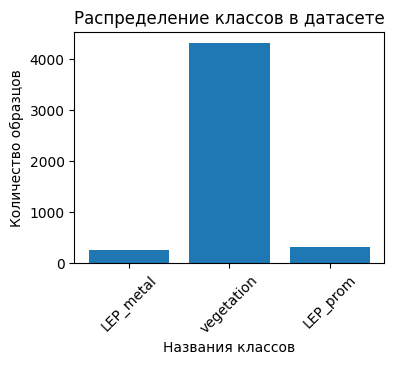

In [6]:
# Отображение распределения классов
labels_counter = Counter(train_labels['class'])
class_names = list(labels_counter.keys())
class_counts = list(labels_counter.values())

plt.figure(figsize=(4, 3))
plt.bar(class_names, class_counts)
plt.xlabel('Названия классов')
plt.ylabel('Количество образцов')
plt.title('Распределение классов в датасете')
plt.xticks(rotation=45)
plt.show()

In [7]:
# Преобразование меток в числа
label_encoder = LabelEncoder()
train_labels['encoded_class'] = label_encoder.fit_transform(train_labels['class'])
num_classes = len(label_encoder.classes_)
print(f"Классы: {label_encoder.classes_}")
print(f"Количество классов: {num_classes}")

Классы: ['LEP_metal' 'LEP_prom' 'vegetation']
Количество классов: 3


# Предобработка данных

In [9]:
def extract_points_from_bounding_box(las_file_path, bbox):
    """
    Извлекает точки из LAS файла, попадающие внутрь bounding-box с учетом yaw.
    
    Parameters:
        las_file_path (str): Путь к LAS файлу.
        bbox (dict): Bounding-box с координатами, размерами и yaw.
                     {'center_x', 'center_y', 'center_z', 'size_x', 'size_y', 'size_z', 'yaw'}
    Returns:
        np.ndarray: Точки внутри bounding-box в формате [X, Y, Z].
    """
    # Открываем файл
    las = laspy.read(las_file_path)
    
    # Преобразуем координаты в локальную систему
    x_global, y_global, z_global = las.x, las.y, las.z
    x_local = x_global - las.header.offsets[0]
    y_local = y_global - las.header.offsets[1]
    z_local = z_global - las.header.offsets[2]

    # Перемещаем точки в центр bounding-box
    x_local -= bbox["center_x"]
    y_local -= bbox["center_y"]
    z_local -= bbox["center_z"]

    # Поворачиваем точки на угол -yaw (чтобы выровнять bounding-box по осям)
    yaw = -bbox["yaw"]
    cos_yaw = np.cos(yaw)
    sin_yaw = np.sin(yaw)
    x_rotated = cos_yaw * x_local - sin_yaw * y_local
    y_rotated = sin_yaw * x_local + cos_yaw * y_local

    # Вычисляем границы bounding-box в повернутой системе координат
    min_x = -bbox["size_x"] / 2
    max_x = bbox["size_x"] / 2
    min_y = -bbox["size_y"] / 2
    max_y = bbox["size_y"] / 2
    min_z = -bbox["size_z"] / 2
    max_z = bbox["size_z"] / 2

    # Фильтруем точки, попадающие в bounding-box
    mask = (
        (x_rotated >= min_x) & (x_rotated <= max_x) &
        (y_rotated >= min_y) & (y_rotated <= max_y) &
        (z_local >= min_z) & (z_local <= max_z)
    )
    points = np.vstack((x_global[mask], y_global[mask], z_global[mask])).T
    return points


def process_las_files_in_parallel(train_labels, train_dir, output_dir, n_jobs=4):
    """
    Обрабатывает все LAS файлы, извлекая bounding-box данные из train_labels.
    
    Parameters:
        train_labels (pd.DataFrame): Метки данных с bounding-box.
        train_dir (str): Папка с LAS файлами.
        output_dir (str): Папка для сохранения предобработанных данных.
        n_jobs (int): Количество потоков для параллельной обработки.
    """
    os.makedirs(output_dir, exist_ok=True)

    def process_single_file(file_name):
        las_file_path = os.path.join(train_dir, file_name)
        bboxes = train_labels[train_labels['file_name'] == file_name]
        metadata = []  # Список для метаинформации файлов
        for idx, row in bboxes.iterrows():
            output_file = os.path.join(output_dir, f"{file_name}_{idx}_{row['class']}.npy")
            # Если файл уже существует, пропускаем
            if os.path.exists(output_file):
                continue
            
            bbox = {
                "center_x": row["center_x"],
                "center_y": row["center_y"],
                "center_z": row["center_z"],
                "size_x": row["size_x"],
                "size_y": row["size_y"],
                "size_z": row["size_z"],
                "yaw": row["yaw"],
            }
            points = extract_points_from_bounding_box(las_file_path, bbox)
            np.save(output_file, points)
            
            # Добавляем запись о метаинформации
            metadata.append({
                "file_name": output_file,
                "class": row["class"],
                "bbox_id": idx
            })
        
        # Сохраняем метаинформацию в CSV
        metadata_file = os.path.join(output_dir, META_CSV)
        metadata_df = pd.DataFrame(metadata)
        if os.path.exists(metadata_file):
            # Дополняем существующий CSV
            metadata_df.to_csv(metadata_file, mode='a', header=False, index=False)
        else:
            # Создаем новый CSV
            metadata_df.to_csv(metadata_file, index=False)
        return f"Processed {file_name}"
    
    # Получаем список уникальных файлов
    unique_files = train_labels['file_name'].unique()
    
    # Обрабатываем файлы параллельно
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_single_file)(file_name) for file_name in tqdm(unique_files)
    )
    print("\n".join(results))

In [ ]:
# Предварительная обработка
# processed_files = process_las_files_in_parallel(train_labels, TRAIN_DIR, PREPROCESS_DIR, n_jobs=NUM_WORKERS)

In [ ]:
# Визуальная проверка 
from mpl_toolkits.mplot3d import Axes3D

def visualize_points(points):
    """
    Визуализирует 3D точки.
    
    Parameters:
        points (np.ndarray): Массив точек в формате [X, Y, Z].
    """
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1, c='blue')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

# Пример визуализации первых данных
example_file = os.path.join(PREPROCESS_DIR, os.listdir(PREPROCESS_DIR)[38])
example_points = np.load(example_file)
visualize_points(example_points)

# Подготовка датасета

In [19]:
# Датасет
class PointCloudDatasetFromNpy(Dataset):
    def __init__(self, data_dir, num_points=1024, label_encoder=None):
        """
        Инициализация датасета.

        Parameters:
            data_dir (str): Директория с файлами .npy.
            num_points (int): Количество точек, которые будут использоваться для выборки из каждого файла.
            label_encoder (LabelEncoder): Кодировщик для классов. Если None, будет создан новый.
        """
        self.data_dir = data_dir
        self.num_points = num_points
        self.file_names = [f for f in os.listdir(data_dir) if f.endswith('.npy')]

        # Извлекаем метки классов из имен файлов
        self.labels = [self._extract_label_from_filename(f) for f in self.file_names]

        # Кодируем классы
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            self.labels_encoded = self.label_encoder.fit_transform(self.labels)
        else:
            self.label_encoder = label_encoder
            self.labels_encoded = self.label_encoder.transform(self.labels)

    def _extract_label_from_filename(self, filename):
        """
        Извлекает класс из имени файла с использованием регулярного выражения.

        Parameters:
            filename (str): Имя файла (например, 'Day1_0_LEP_metal.npy').

        Returns:
            str: Название класса ('LEP_metal', 'LEP_prom', или 'vegetation').
        """
        # Регулярное выражение для поиска допустимых меток
        match = re.search(r'(LEP_metal|LEP_prom|vegetation)', filename)
        if match:
            return match.group(1)
        else:
            raise ValueError(f"Не удалось извлечь класс из имени файла: {filename}")

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        # Загружаем точки из файла
        file_path = os.path.join(self.data_dir, self.file_names[idx])
        points = np.load(file_path)

        # Случайная выборка точек
        if len(points) >= self.num_points:
            indices = np.random.choice(len(points), self.num_points, replace=False)
        else:
            indices = np.random.choice(len(points), self.num_points, replace=True)
        points_sampled = points[indices]

        # Нормализация точек
        points_sampled = points_sampled - np.mean(points_sampled, axis=0)
        scale = np.max(np.linalg.norm(points_sampled, axis=1))
        if scale > 0:
            points_sampled = points_sampled / scale

        # Получаем закодированную метку
        label = self.labels_encoded[idx]
        return torch.tensor(points_sampled, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# Аугментация
class PointCloudAugmentation:
    @staticmethod
    def random_shift(points):
        shift = np.random.uniform(-0.1, 0.1, size=(1, 3))  # уменьшили диапазон
        return points + shift

    @staticmethod
    def random_scale(points):
        scale = np.random.uniform(0.9, 1.1)  # уменьшили диапазон масштабирования
        return points * scale

    @staticmethod
    def random_jitter(points, sigma=0.005, clip=0.02):  # уменьшили уровень шума
        jitter = np.clip(sigma * np.random.randn(*points.shape), -clip, clip)
        return points + jitter

    def __call__(self, points):
        points = self.random_shift(points)
        points = self.random_scale(points)
        points = self.random_jitter(points)
        return points

In [ ]:
# Создание датасета
dataset = PointCloudDatasetFromNpy(data_dir=PREPROCESS_DIR, num_points=NUM_POINTS)

# Проверка классов
print(np.unique(dataset.labels))
print(dataset.label_encoder.classes_)

In [ ]:
# Разделение на обучающую и валидационную выборки
train_indices, val_indices = train_test_split(
    range(len(dataset)),
    test_size=0.2,
    stratify=dataset.labels_encoded
)

from torch.utils.data import Subset

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

print(f"Размер обучающей выборки: {len(train_dataset)}")
print(f"Размер валидационной выборки: {len(val_dataset)}")

In [ ]:
# Балансировка классов
train_labels = [train_dataset.dataset[idx][1] for idx in train_dataset.indices]
train_labels = np.array(train_labels)
class_weights = compute_class_weight('balanced', classes=np.arange(NUM_CLASSES), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)
criterion = nn.NLLLoss(weight=class_weights)

# Создаем WeightedRandomSampler для балансировки
class_counts = np.bincount(train_labels)
weights = 1.0 / class_counts
sample_weights = weights[train_labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_dataset))

In [ ]:
# Создание даталоадеров 
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=0, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, drop_last=True)

In [ ]:
# Проверка
points, labels = next(iter(train_loader))
print(f"Размер точек: {points.shape}, Метки: {labels}")

# Модель

In [30]:
# Базовая PointNet
class PointNet(nn.Module):
    def __init__(self, num_classes):
        super(PointNet, self).__init__()
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.permute(0, 2, 1)

        # Применение сверточных слоев с BatchNorm и ReLU
        x = F.relu(self.bn1(self.conv1(x)))  # [batch_size, 64, num_points]
        x = F.relu(self.bn2(self.conv2(x)))  # [batch_size, 128, num_points]
        x = F.relu(self.bn3(self.conv3(x)))  # [batch_size, 1024, num_points]

        # Глобальный max pooling по точкам
        x = torch.max(x, 2)[0]  # [batch_size, 1024]

        # Полносвязные слои с BatchNorm, ReLU и Dropout
        x = F.relu(self.bn4(self.fc1(x)))  # [batch_size, 512]
        x = F.relu(self.bn5(self.fc2(x)))  # [batch_size, 256]
        x = self.dropout(x)

        # Выходной слой
        x = self.fc3(x) 

        return F.log_softmax(x, dim=1)

In [22]:
# PointNet++ с трансформером

class ResidualBlock(nn.Module):
    """
    Residual Block для выделения локальных признаков.
    """
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, 1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, 1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.shortcut = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        shortcut = self.shortcut(x)  # Сохранение входного значения
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        return F.relu(x + shortcut)  # Добавление остаточного соединения
        

class DGCNNLayer(nn.Module):
    """
    DGCNN Layer для извлечения локальных признаков на основе графа.
    """
    def __init__(self, in_channels, out_channels, k=5):
        super(DGCNNLayer, self).__init__()
        self.k = k  # Число соседей
        self.conv = nn.Conv2d(in_channels * 2, out_channels, 1)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        batch_size, num_points, num_features = x.size()

        # Вычисление попарных расстояний
        inner = -2 * torch.matmul(x, x.transpose(2, 1))
        xx = torch.sum(x ** 2, dim=-1, keepdim=True)
        pairwise_distance = -xx - inner - xx.transpose(2, 1)

        # Поиск k ближайших соседей
        _, idx = torch.topk(pairwise_distance, self.k, dim=-1)

        # Извлечение признаков соседей
        idx = idx.unsqueeze(-1).expand(-1, -1, -1, num_features)
        neighbors = torch.gather(x.unsqueeze(1).expand(-1, num_points, -1, -1), 2, idx)
        central_points = x.unsqueeze(2).expand(-1, -1, self.k, -1)
        edge_features = torch.cat([central_points, neighbors - central_points], dim=-1)

        # Преобразование для Conv2d
        x = edge_features.permute(0, 3, 1, 2)

        # Применение свертки
        x = F.relu(self.bn(self.conv(x)))

        # Агрегация признаков (максимум по соседям)
        return torch.max(x, dim=-1)[0]

class AttentionModule(nn.Module):
    """
    Attention Module для выделения наиболее важных признаков.
    """
    def __init__(self, channels):
        super(AttentionModule, self).__init__()
        self.attn = nn.Sequential(
            nn.Conv1d(channels, channels // 16, 1),
            nn.ReLU(),
            nn.Conv1d(channels // 16, channels, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        attn_weights = self.attn(x)
        return x * attn_weights


class GlobalAggregation(nn.Module):
    """
    Global Aggregation для объединения глобальных признаков со всех точек.
    """
    def __init__(self):
        super(GlobalAggregation, self).__init__()
        self.max_pool = nn.AdaptiveMaxPool1d(1)
        self.avg_pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):
        max_pool = self.max_pool(x).squeeze(-1)
        avg_pool = self.avg_pool(x).squeeze(-1)
        sum_pool = torch.sum(x, dim=2)
        return torch.cat([max_pool, avg_pool, sum_pool], dim=1)

class TransformerBlock(nn.Module):
    """
    Transformer Block для захвата глобальных связей между признаками.
    """
    def __init__(self, d_model, nhead, dim_feedforward=1024, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.self_attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=nhead, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        x = x.permute(1, 0, 2)  # [num_points, batch_size, d_model]
        attn_output, _ = self.self_attn(x, x, x)
        x = self.norm1(x + attn_output)
        ff_output = self.linear2(self.dropout(F.relu(self.linear1(x))))
        x = self.norm2(x + ff_output)
        return x.permute(1, 0, 2)  # [batch_size, num_points, d_model]
        

class PointNetPlusPlusTransformer(nn.Module):
    """
    Основная модель PointNet++ с трансформером для обработки облаков точек.
    """
    def __init__(self, num_classes, input_channels=3):
        super(PointNetPlusPlusTransformer, self).__init__()

        # Блоки выделения локальных признаков
        self.sa1 = ResidualBlock(input_channels, 64)
        self.sa2 = ResidualBlock(64, 128)
        self.sa3 = ResidualBlock(128, 256)
        self.dgcnn = DGCNNLayer(256, 256, k=5)

        # Глобальная агрегация
        self.global_conv = nn.Conv1d(256, 1024, 1)
        self.global_bn = nn.BatchNorm1d(1024)
        self.global_agg = GlobalAggregation()

        # Трансформер и внимание
        self.transformer = TransformerBlock(d_model=3072, nhead=4, dim_feedforward=1024, dropout=0.1)
        self.global_attn = AttentionModule(3072)

        # Полносвязные слои
        self.fc1 = nn.Linear(3072, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Обработка через слои выделения признаков
        x = x.permute(0, 2, 1)  # [batch_size, num_points, channels]
        x = self.sa1(x)
        x = self.sa2(x)
        x = self.sa3(x)
        x = x.permute(0, 2, 1)  # [batch_size, channels, num_points]
        x = self.dgcnn(x)

        # Глобальная агрегация
        x = F.relu(self.global_bn(self.global_conv(x)))
        x = self.global_agg(x)

        # Обработка через трансформер
        x = x.unsqueeze(1)
        x = self.transformer(x)
        x = x.squeeze(1)

        # Применение внимания
        x = self.global_attn(x.unsqueeze(-1)).squeeze(-1)

        # Полносвязные слои
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)

        return F.log_softmax(x, dim=1)

In [ ]:
# Инициализация модели
augmenter = PointCloudAugmentation()
model = PointNetPlusPlusTransformer(num_classes=NUM_CLASSES).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
#scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-3, step_size_up=100, mode='triangular')

In [ ]:
# Проверка
points, labels = next(iter(train_loader))
print("Размерность точек:", points.shape)  # (batch_size, num_points, 3)
print("Размерность меток:", labels.shape)  # (batch_size,)
print("Образцы точек:", points[0])
print("Образец метки:", labels[0])

# Обучение модели

In [ ]:
from sklearn.metrics import average_precision_score

def compute_map(predictions, ground_truths, max_distance=5, num_classes=3):
    """
    Вычисление Mean Average Precision (mAP) с использованием KDTree для ускорения.

    Args:
        predictions: Список предсказаний.
        ground_truths: Список истинных меток.
        max_distance: Максимальное расстояние для учета как TP.
        num_classes: Количество классов.

    Returns:
        mAP: Значение Mean Average Precision.
    """
    aps = []
    for cls in range(num_classes):
        y_true = []
        y_scores = []
        gt_matched = set()

        pred_cls = [p for p in predictions if p['class'] == cls]
        gt_cls = [g for g in ground_truths if g['class'] == cls]

        if len(gt_cls) > 0:
            gt_centers = np.array([[g['center_x'], g['center_y'], g['center_z']] for g in gt_cls])
            tree = KDTree(gt_centers)
        else:
            tree = None

        for pred in pred_cls:
            pred_center = np.array([pred['center_x'], pred['center_y'], pred['center_z']])
            pred_score = pred['score']
            y_scores.append(pred_score)

            if tree is not None:
                dist, idx = tree.query(pred_center, distance_upper_bound=max_distance)
                if dist <= max_distance and idx not in gt_matched:
                    y_true.append(1)
                    gt_matched.add(idx)
                else:
                    y_true.append(0)
            else:
                y_true.append(0)

        if len(y_true) == 0:
            y_scores = [0] * len(pred_cls)

        if len(y_true) > 0 and len(y_scores) > 0:
            ap = average_precision_score(y_true, y_scores)
            aps.append(ap)
        else:
            aps.append(0)

    return np.mean(aps) if len(aps) > 0 else 0

In [ ]:
# Цикл обучения
best_val_map = 0.0
early_stopping_patience = 15  # Количество эпох для EarlyStop
patience_counter = 0

augmenter = PointCloudAugmentation()

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    # === ТРЕНИРОВОЧНЫЙ ЭТАП ===
    for points, labels in tqdm(train_loader, desc=f"Эпоха {epoch+1}/{NUM_EPOCHS}", leave=False):
        # Аугментация данных
        points = points.numpy()
        points = np.array([augmenter(p) for p in points])
        points = torch.tensor(points, dtype=torch.float32)

        points, labels = points.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(points)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    scheduler.step()

    avg_loss = running_loss / len(train_loader)
    train_accuracy = 100 * train_correct / train_total
    print(f"Эпоха {epoch+1}/{NUM_EPOCHS}: Потеря (train): {avg_loss:.4f}, Точность (train): {train_accuracy:.2f}%")

    # === ВАЛИДАЦИОННЫЙ ЭТАП ===
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    predictions = []
    ground_truths = []

    with torch.no_grad():
        for points, labels in tqdm(val_loader, desc="Валидация"):
            points, labels = points.to(DEVICE), labels.to(DEVICE)
            outputs = model(points)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Сохранение предсказаний и истинных меток для расчета mAP
            for i in range(labels.size(0)):
                yaw = calculate_yaw(points[i].cpu().numpy())
                predictions.append({
                    'class': predicted[i].item(),
                    'center_x': points[i][:, 0].mean().item(),
                    'center_y': points[i][:, 1].mean().item(),
                    'center_z': points[i][:, 2].mean().item(),
                    'yaw': yaw,
                    'score': torch.exp(outputs[i, predicted[i]]).item()
                })
                ground_truths.append({
                    'class': labels[i].item(),
                    'center_x': points[i][:, 0].mean().item(),
                    'center_y': points[i][:, 1].mean().item(),
                    'center_z': points[i][:, 2].mean().item()
                })

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    val_map = compute_map(predictions, ground_truths, max_distance=5, num_classes=NUM_CLASSES)

    print(f"Эпоха {epoch+1}/{NUM_EPOCHS}: Валидация — Потеря: {avg_val_loss:.4f}, Точность: {val_accuracy:.2f}%, mAP: {val_map:.4f}")

    # === СОХРАНЕНИЕ ЛУЧШЕЙ МОДЕЛИ ===
    if val_map > best_val_map:
        best_val_map = val_map
        patience_counter = 0
        torch.save(model.state_dict(), f'PointNetPP_epoch_{epoch+1}.pth')
        print(f"Сохранена модель с mAP {best_val_map:.4f}.")
    else:
        patience_counter += 1

    # === ПРОВЕРКА НА EARLY STOPPING ===
    if patience_counter >= early_stopping_patience:
        print("Досрочная остановка обучения из-за отсутствия улучшений.")
        break

print(f"Обучение завершено. Лучшая mAP: {best_val_map:.4f}")

# Предсказание

In [26]:
# Расчёт угла поворота
def calculate_yaw(points):
    if len(points) > 1:
        vector = points[-1, :2] - points[0, :2]
        yaw = np.arctan2(vector[1], vector[0])
    else:
        yaw = 0.0
    return yaw

# Обработка ячеек батчами
def process_cells_in_batch(cell_points_dict, file_name, label_encoder, score_threshold, model, device, num_points):
    batch_points = []
    batch_indices = []

    # Формируем батчи для параллельного предсказания
    for idx, cell_points in cell_points_dict.items():
        cell_points = np.array(cell_points)
        num_cell_points = len(cell_points)

        if num_cell_points >= num_points:
            # Случайная выборка num_points точек
            selected_indices = np.random.choice(num_cell_points, num_points, replace=False)
            cell_points_sampled = cell_points[selected_indices]
        else:
            continue  # Пропускаем ячейки с недостаточным количеством точек

        # Вычисление центра ячейки и нормализация точек
        center_local = np.mean(cell_points_sampled, axis=0)
        cell_points_centered = cell_points_sampled - center_local
        scale = np.max(np.linalg.norm(cell_points_centered, axis=1))
        if scale > 0:
            cell_points_normalized = cell_points_centered / scale
        else:
            cell_points_normalized = cell_points_centered

        batch_points.append(cell_points_normalized)
        batch_indices.append((idx, center_local, cell_points_sampled))

    if not batch_points:
        return []

    # Преобразование в тензор и выполнение предсказания модели
    batch_points = np.array(batch_points)
    batch_tensor = torch.tensor(batch_points, dtype=torch.float32).to(device)
    with torch.no_grad():
        outputs = model(batch_tensor)
        probabilities = torch.exp(outputs)
        predicted_labels = outputs.argmax(dim=1).cpu().numpy()
        scores = probabilities.max(dim=1)[0].cpu().numpy()

    # Формирование списка баундинг-боксов для всех ячеек в батче
    bboxes = []
    for i, (idx, center_local, cell_points_sampled) in enumerate(batch_indices):
        if scores[i] >= score_threshold:
            size_x = max(np.ptp(cell_points_sampled[:, 0]), 0.1)
            size_y = max(np.ptp(cell_points_sampled[:, 1]), 0.1)
            size_z = max(np.ptp(cell_points_sampled[:, 2]), 0.1)
            
            # Вычисление yaw
            yaw = calculate_yaw(cell_points_sampled)
            
            bbox = {
                'file_name': file_name,
                'center_x': center_local[0],
                'center_y': center_local[1],
                'center_z': center_local[2],
                'size_x': size_x,
                'size_y': size_y,
                'size_z': size_z,
                'yaw': yaw,
                'class': label_encoder.inverse_transform([predicted_labels[i]])[0],
                'score': scores[i]
            }
            bboxes.append(bbox)

    return bboxes

# Обработка тестового файла
def process_test_file(file_name, test_dir, model, label_encoder, num_points, device, score_threshold=0.5, grid_size=10.0):
    file_path = os.path.join(test_dir, file_name)
    bbox_list = []

    # Загрузка точек из файла
    las = laspy.read(file_path)
    points_global = las.xyz.astype(np.float32)

    # Преобразование в локальные координаты
    offsets = np.array(las.header.offsets, dtype=np.float32)
    points = points_global - offsets

    del las, points_global
    gc.collect()

    # Разделение точек на ячейки
    indices = np.floor(points / grid_size).astype(np.int32)
    unique_indices, inverse_indices = np.unique(indices, axis=0, return_inverse=True)

    # Группировка точек по ячейкам
    cell_points_dict = defaultdict(list)
    for idx, point in zip(inverse_indices, points):
        cell_points_dict[idx].append(point)

    # Параллельная обработка ячеек
    pbar = tqdm(total=len(cell_points_dict), desc=f"Обработка ячеек в файле {file_name}")
    results = []
    for idx in cell_points_dict.keys():
        result = process_cells_in_batch(
            {idx: cell_points_dict[idx]},
            file_name,
            label_encoder,
            score_threshold,
            model,
            device,
            num_points
        )
        results.extend(result)
        pbar.update(1)
    pbar.close()

    bbox_list.extend(results)
    return bbox_list

# Обработка всех тестовых файлов
def predict_and_combine(test_dir, model, output_csv, label_encoder, num_points=512, score_threshold=0.5, grid_size=5.0, min_size_z=1.0):
    model.eval()
    test_files = [f for f in os.listdir(test_dir) if f.endswith('.las')]
    combined_results = []
    current_id = 1

    for file_name in tqdm(test_files, desc="Обработка тестовых файлов"):
        with torch.no_grad():
            bbox_list = process_test_file(
                file_name, test_dir, model, label_encoder, num_points, DEVICE, score_threshold, grid_size
            )

        # Применяем постобработку, не обрабатываем объекты менее заданной высоты
        filtered_bboxes = []
        for bbox in bbox_list:
            if bbox['size_z'] < min_size_z:
                continue

            bbox['id'] = current_id  # Уникальный ID
            filtered_bboxes.append(bbox)
            current_id += 1

        combined_results.extend(filtered_bboxes)

    # Проверяем, есть ли результаты
    if combined_results:
        combined_df = pd.DataFrame(combined_results)
        columns = ['id', 'file_name', 'center_x', 'center_y', 'center_z',
                   'size_x', 'size_y', 'size_z', 'yaw', 'class', 'score']
        combined_df = combined_df[columns]
        combined_df.to_csv(output_csv, index=False)
        print(f"Результаты сохранены в {output_csv}")
    else:
        print("Нет результатов для сохранения.")

In [36]:
# Загрузка модели
model = PointNet(num_classes=NUM_CLASSES).to(DEVICE)
model.load_state_dict(torch.load('PointNetPP_epoch_10.pth', map_location=DEVICE), strict=False)
model = model.to(DEVICE)

# Установка параметров постобработки
min_size_z = 1.0  # Минимальный размер объекта по оси Z

# Запуск предсказания
predict_and_combine_optimized(test_dir=TEST_DIR,
                    model=model,
                    output_csv=OUTPUT_CSV,
                    label_encoder=label_encoder,
                    num_points=512,
                    score_threshold=0.5,
                    grid_size=10.0,
                    min_size_z=min_size_z)

C:\Users\Sagi\AppData\Local\Temp\ipykernel_11048\1211678664.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_imppointnet_model4_epo